In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from sklearn.model_selection import train_test_split


In [2]:
import re
import string
from nltk.corpus import stopwords
import nltk

## Data Import

In [3]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-reviews-for-sentianalysis-finegrained-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2078107%2F3499094%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T150806Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D0384286882e57ed5979a453d3b36e2d5ac7c5683c21364a514272ce697b7a7430176301d285f6982230aa12ded3cf24f63136365e5939a1b4cf6a627f90b21b558772ac2b852ceeda8c9115147d5d45101662dbded2dc256b64c8607b23b8a2e138946585e223ab27c2e6ced66542d64b390b7a29fb5f28667574314b9b5d6a1e728981f43b957023ed099b2adfc9609101a051eb013f254b576ffd5c986f20ab81845f69f45dcde2f9c5e05f1e3fc15e3aed90b0112a274ad37e14053eb8e6d8635f649c8362c1478bc8b587d074f6474c488f679d16695f5ed6a20ddea00f6dc13ab4b1746b75013f78e36b46727d42ca74c2ba6b6d35bd214cd27c5751ebb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 654512809 bytes downloaded
Downloaded and uncompressed: amazon-reviews-for-sentianalysis-finegrained-csv
Data source import complete.


## Import Data

In [4]:
train = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/train.csv')
test = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/test.csv')



## Check Format

In [5]:
print('Training dataset')
train.head(4)

Training dataset


,class_index,review_title,review_text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...


In [6]:
print('Testing dataset')
test.head(4)

Testing dataset


,class_index,review_title,review_text
0,1,mens ultrasheer,"This model may be ok for sedentary types, but ..."
1,4,Surprisingly delightful,This is a fast read filled with unexpected hum...
2,2,"Works, but not as advertised",I bought one of these chargers..the instructio...
3,2,Oh dear,I was excited to find a book ostensibly about ...


In [7]:
train_sample = train.sample(n=50000, random_state=20)
test_sample = test.sample(n=15000, random_state=20)

## Data Preprocessing

In [8]:
#Text Cleaning
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
# Clean the review texts in the training sample
train_sample['cleaned_review'] = train_sample['review_text'].apply(clean_text)

# Cleaned review text for tokenization
texts = train_sample['cleaned_review'].astype(str).values  # Use cleaned review text for tokenization
labels = train_sample['class_index'].values  # Use class_index as labels


In [11]:
# Tokenization
max_length = 200  # Max length for each review
vocab_size = 10000  # Vocabulary size (can tune this)
tokenizer = Tokenizer(num_words=vocab_size, oov_token='')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')  # Padding

In [12]:
# Convert sentiment classes to numerical labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert to categorical (one-hot encoding)
categorical_labels = to_categorical(encoded_labels, num_classes=5)

In [13]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, categorical_labels, test_size=0.2, random_state=40)

In [14]:
# Check the shape of the padded sequences
print("Shape of padded_sequences:", padded_sequences.shape)

Shape of padded_sequences: (50000, 200)


In [15]:
# Define RNN model
model = Sequential()

model.add(Embedding(input_dim=vocab_size, output_dim=128))  # Embedding layer (1st layer)
model.add(SimpleRNN(64, return_sequences=False, activation='relu')) # Added RelU activation function to the second Layer with 64 Units

model.add(Dropout(0.5))  # Dropout for regularization

model.add(Dense(32, activation='relu')) # Dense layer with 32 units and ReLU activation
model.add(Dense(5, activation='softmax'))  # Output layer with softmax activation

## Learning Rate Adjustment

In [22]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.0001)  # Lower learning rate

In [16]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## Using Class Weights

In [18]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(encoded_labels), y=encoded_labels)

# Convert class weights to a dictionary format
class_weights_dict = dict(enumerate(class_weights))

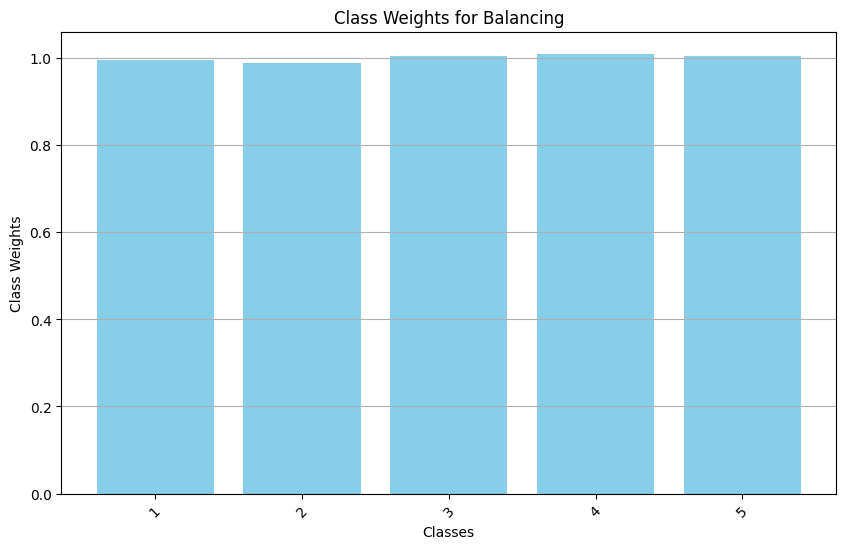

In [19]:
# Plotting class weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(class_weights)), class_weights, color='skyblue')
plt.xticks(range(len(class_weights)), label_encoder.classes_, rotation=45)  # Class names on x-axis
plt.xlabel('Classes')
plt.ylabel('Class Weights')
plt.title('Class Weights for Balancing')
plt.grid(axis='y')
plt.show()

## Model Training

In [24]:
# Training the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=32,
                    verbose=1)  # to see progress


Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 86s 69ms/step - accuracy: 0.1963 - loss: 1.6095 - val_accuracy: 0.2027 - val_loss: 1.6094
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 68ms/step - accuracy: 0.2000 - loss: 1.6095 - val_accuracy: 0.2020 - val_loss: 1.6095
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 68ms/step - accuracy: 0.2000 - loss: 1.6095 - val_accuracy: 0.2020 - val_loss: 1.6094
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 68ms/step - accuracy: 0.2023 - loss: 1.6095 - val_accuracy: 0.1962 - val_loss: 1.6095
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 143s 69ms/step - accuracy: 0.2007 - loss: 1.6095 - val_accuracy: 0.2020 - val_loss: 1.6095
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 141s 68ms/step - accuracy: 0.2013 - loss: 1.6096 - val_accuracy: 0.2020 - val_loss: 1.6094
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - accuracy: 0.2005 - loss: 1.6095 - val_accuracy: 0.2020 - val_loss: 1.6095
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 142s 68ms/step - accuracy: 0.